### Precio de Bitcoin. Predicción de ARIMA

**Propósito**: Tener una plantilla simplificada para comprender el pronóstico de series de tiempo con el modelo ARIMA en Python, actuando más como un tutorial.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

### P1.- ¿Qué es una serie de tiempo?

La serie de tiempo es una serie de observaciones tomadas en intervalos de tiempo específicos, generalmente intervalos iguales. El análisis de la serie nos ayuda a predecir valores futuros basados en valores observados anteriormente. En Series de tiempo, solo tenemos 2 variables, el tiempo y la variable que queremos pronosticar.

### P2.- ¿Por qué y dónde se utiliza la serie de tiempo?

Los datos de series de tiempo se pueden analizar para extraer estadísticas significativas y otras características. Se utiliza en al menos 4 escenarios:

    a) Proyección comercial
    b) Comprender el comportamiento pasado
    c) Planifica el futuro
    d) Evaluar el logro actual

### P3.- ¿Cuáles son los componentes de las series de tiempo?

Hay 4 componentes:

        a) Tendencia: movimiento ascendente y descendente de los datos con el tiempo durante un largo período de tiempo.
        b) Estacionalidad: variaciones estacionales.
        c) Ruido o irregularidad: picos y depresiones a intervalos aleatorios
        d) Ciclicidad: comportamiento que se repite después de un gran intervalo de tiempo, como meses, años, etc.

Cargaremos el dataset de información de bitcoins

In [2]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Unix-time to 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

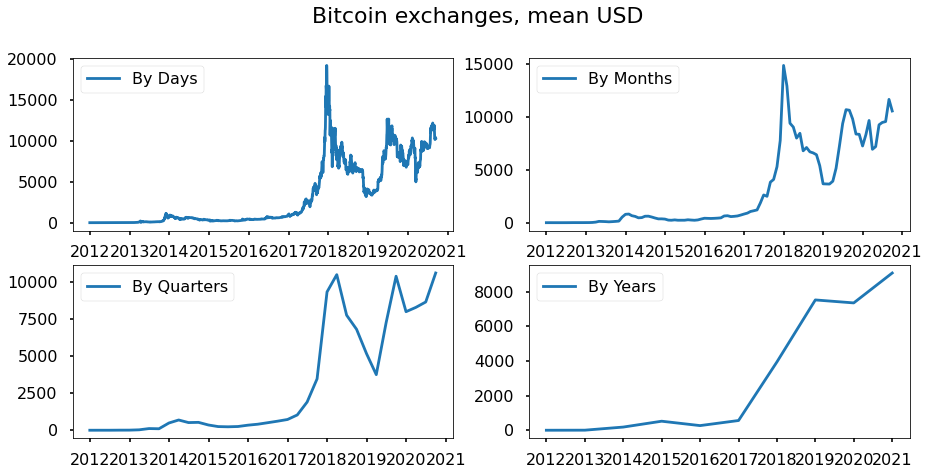

In [4]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

plt.show()

## Predecirán el precio de las bitcoins por meses...
### Verificación de estacionariedad y descomposición STL de la serie

Dickey–Fuller test: p=0.617866


<Figure size 1080x504 with 0 Axes>

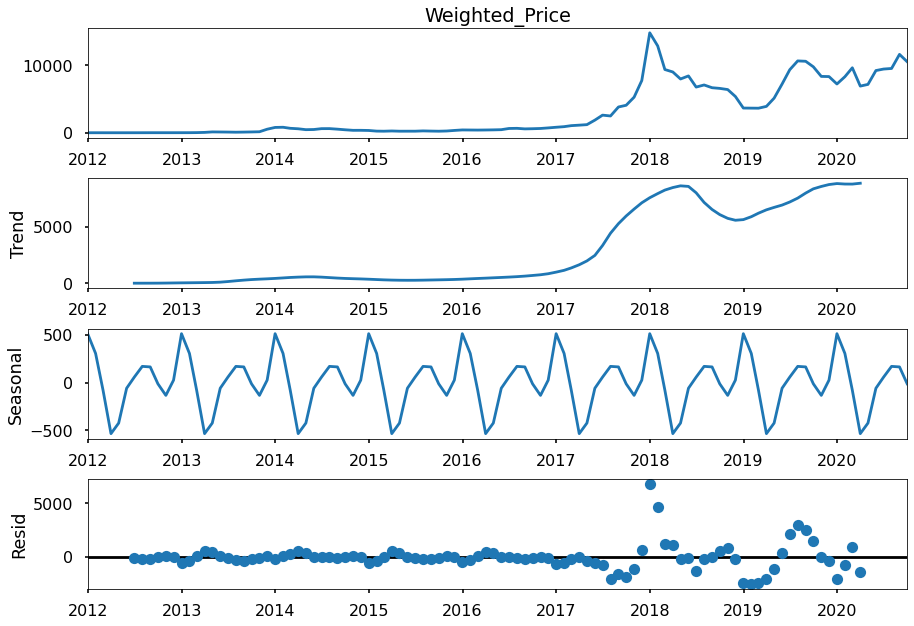

In [5]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

In [6]:
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.617866


In [7]:
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.288535


Dickey–Fuller test: p=0.000002


<Figure size 1080x504 with 0 Axes>

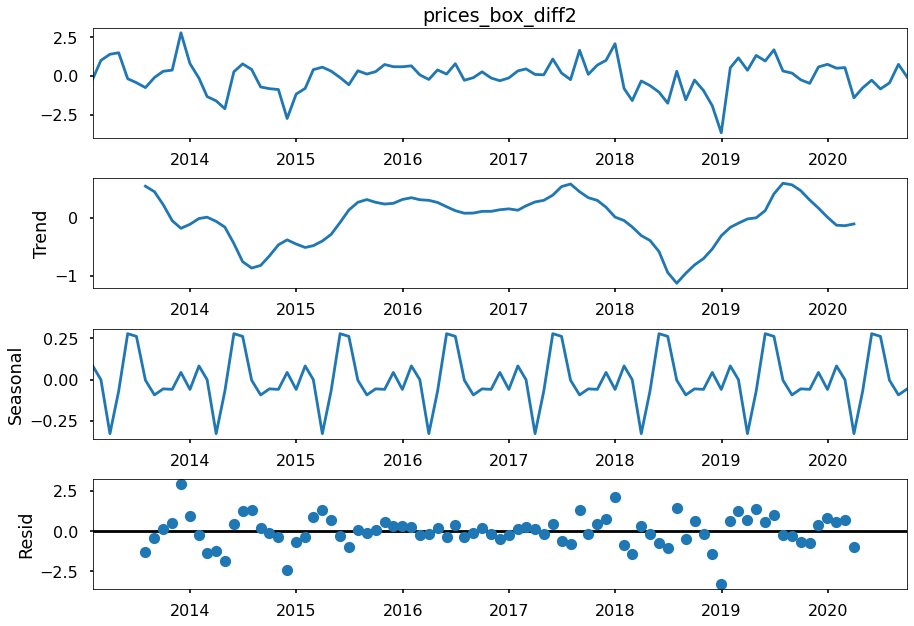

In [8]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

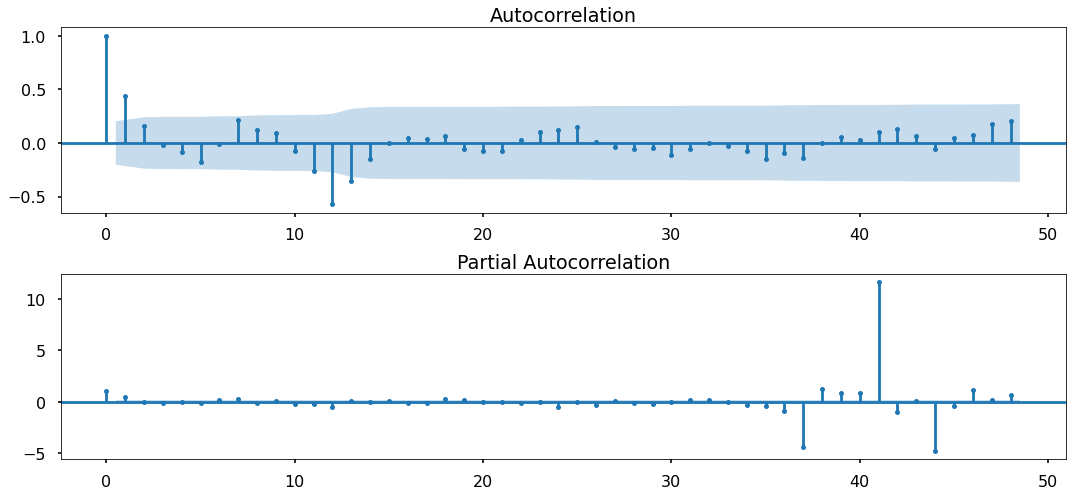

In [9]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [10]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [11]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
11  (0, 1, 2, 1)  198.825567
23  (1, 0, 2, 1)  198.882307
19  (1, 0, 0, 1)  199.158384
21  (1, 0, 1, 1)  199.434530
7   (0, 1, 0, 1)  199.518126
                                     SARIMAX Results                                      
Dep. Variable:                 Weighted_Price_box   No. Observations:                  106
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -94.413
Date:                            Fri, 15 Oct 2021   AIC                            198.826
Time:                                    15:29:30   BIC                            211.489
Sample:                                12-31-2011   HQIC                           203.939
                                     - 09-30-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

### P4.- ¿Qué es ADF_Test, ACF, PACF, ARIMA y SARIMA? ¿Para qué se usan?

La prueba **Augmented Dickey-Fuller** es un tipo de prueba estadística denominada prueba de raíz unitaria. Determina la fuerza con la que una serie de tiempo está definida por una tendencia.

Utiliza un modelo autorregresivo y optimiza un criterio de información a través de múltiples valores de retardo diferentes.

La hipótesis nula de la prueba es que la serie de tiempo se puede representar mediante una raíz unitaria, que no es estacionaria (tiene alguna estructura dependiente del tiempo). La hipótesis alternativa (rechazando la hipótesis nula) es que la serie de tiempo es estacionaria.

Interpretamos este resultado utilizando el valor p de la prueba. Un valor p por debajo de un umbral (como 5% o 1%) sugiere que rechazamos la hipótesis nula (estacionaria); de lo contrario, un valor p por encima del umbral sugiere que no rechazamos la hipótesis nula (no estacionaria).

   * Valor p> 0.05: No se rechaza la hipótesis nula (H0), los datos tienen una raíz unitaria y no son estacionarios.
   * Valor p <= 0.05: Rechaza la hipótesis nula (H0), los datos no tienen raíz unitaria y son estacionarios.
   
---

**ARIMA** es un acrónimo de AutoRegressive Integrated Moving Average. Es una generalización de la media móvil autorregresiva más simple y agrega la noción de integración.

Este acrónimo es descriptivo y captura los aspectos clave del modelo en sí. Brevemente, son:

    AR: Autoregresión. Un modelo que utiliza la relación dependiente entre una observación y cierto número de observaciones retrasadas.
    I: Integrado. El uso de la diferenciación de observaciones en bruto (por ejemplo, restar una observación de una observación en el paso de tiempo anterior) para hacer estacionaria la serie de tiempo.
    MA: Media móvil. Modelo que utiliza la dependencia entre una observación y un error residual de un modelo de promedio móvil aplicado a observaciones retrasadas.
    
---

**Gráficos ACF y PACF**: después de que una serie de tiempo ha sido estacionaria por diferenciación, el siguiente paso para ajustar un modelo ARIMA es determinar si los términos AR o MA son necesarios para corregir cualquier autocorrelación que quede en la serie diferenciada. 

Al observar los gráficos de la función de autocorrelación (ACF) y de autocorrelación parcial (PACF) de la serie diferenciada, puede identificar provisionalmente el número de términos AR y / o MA que se necesitan. Ya está familiarizado con el gráfico ACF: es simplemente un gráfico de barras de los coeficientes de correlación entre una serie de tiempo y rezagos de sí mismo. La gráfica PACF es una gráfica de los coeficientes de correlación parcial entre la serie y los rezagos de sí misma.

En general, la correlación "parcial" entre dos variables es la cantidad de correlación entre ellas que no se explica por sus correlaciones mutuas con un conjunto específico de otras variables. 

Por ejemplo, si estamos regresando una variable Y sobre otras variables X1, X2 y X3, la correlación parcial entre Y y X3 es la cantidad de correlación entre Y y X3 que no se explica por sus correlaciones comunes con X1 y X2. Esta correlación parcial se puede calcular como la raíz cuadrada de la reducción en la varianza que se logra sumando X3 a la regresión de Y en X1 y X2.

Una autocorrelación parcial es la cantidad de correlación entre una variable y un rezago de sí misma que no se explica por correlaciones en todos los rezagos de orden inferior.

Dickey–Fuller test:: p=0.000000


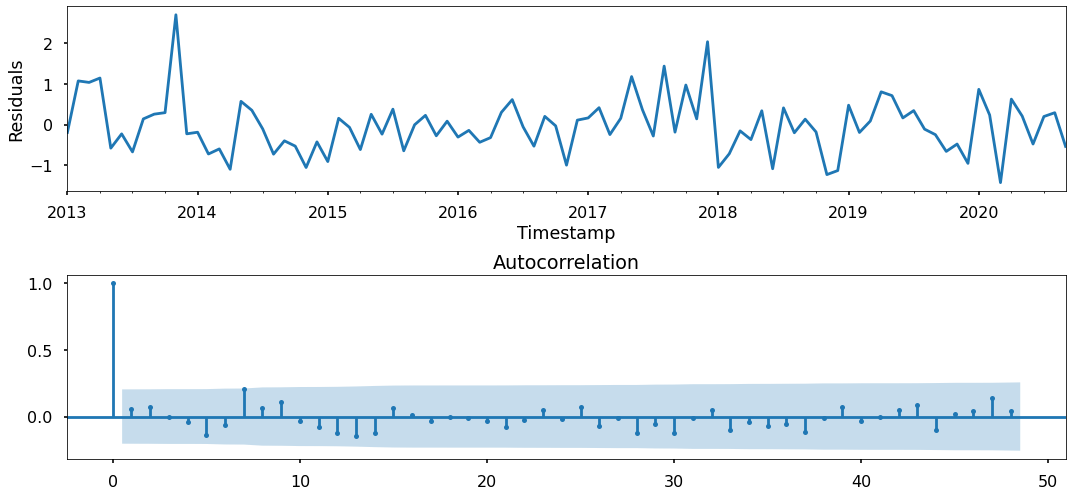

In [12]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

### Predicciones...

In [13]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

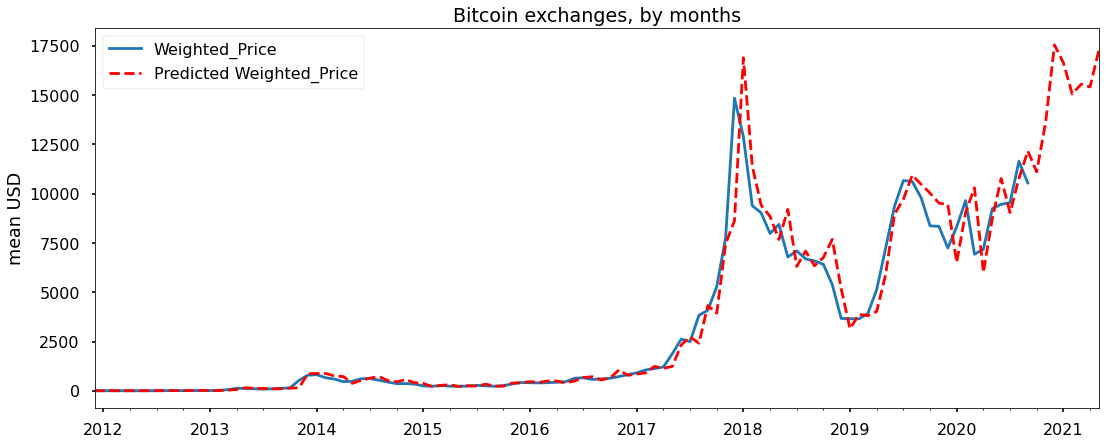

In [14]:
# Prediction
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2020, 10, 31), datetime(2020, 11, 30), datetime(2020, 12, 31), 
             datetime(2021, 1, 31), datetime(2021, 2, 28), 
             datetime(2021, 3, 31), datetime(2021, 4, 30), datetime(2021, 5, 31)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=113), lmbda)
plt.figure(figsize=(18,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

In [15]:
df_month2[['Weighted_Price', 'forecast']].tail(10)

,Weighted_Price,forecast
2020-08-31,11637.080012,10765.802149
2020-09-30,10541.968835,12162.378618
2020-10-31,NaN,11106.451328
2020-11-30,NaN,13602.948468
2020-12-31,NaN,17545.228190
2021-01-31,NaN,16635.371162
2021-02-28,NaN,15055.532407
2021-03-31,NaN,15551.343205
2021-04-30,NaN,15413.246781
2021-05-31,NaN,17285.061461


### ¿Qué podemos inferir de estas cosas?

Parece que será buen momento para vender bitcoins...